In [ ]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 

In [65]:
data = pd.read_csv("./raw_data/GSE45827_series_matrix.txt", sep = "\t", comment = "!")

In [66]:
data = data.dropna(axis = 0) 

In [67]:
soft_map = pd.read_csv("./raw_data/GPL570-55999.txt", sep = "\t", comment = "#", dtype = object)
soft_map = soft_map.loc[:, ['ID', 'Gene Symbol']]
soft_map

,ID,Gene Symbol
0,1007_s_at,DDR1 /// MIR4640
1,1053_at,RFC2
2,117_at,HSPA6
3,121_at,PAX8
4,1255_g_at,GUCA1A
...,...,...
54670,AFFX-ThrX-5_at,NaN
54671,AFFX-ThrX-M_at,NaN
54672,AFFX-TrpnX-3_at,NaN
54673,AFFX-TrpnX-5_at,NaN


In [68]:
soft_map.set_index("ID", inplace = True) 

soft_map = soft_map.loc[data['ID_REF']]
soft_map

,Gene Symbol
ID,
1007_s_at,DDR1 /// MIR4640
1053_at,RFC2
117_at,HSPA6
1294_at,MIR5193 /// UBA7
1316_at,THRA
...,...
91684_g_at,EXOSC4
91703_at,EHBP1L1
91816_f_at,MEX3D


In [69]:
soft_map.dropna(axis = 0, inplace = True)
soft_map['Gene Symbol'] = list(map(lambda x: x.split("///")[0], soft_map['Gene Symbol']))

In [70]:
soft_map

,Gene Symbol
ID,
1007_s_at,DDR1
1053_at,RFC2
117_at,HSPA6
1294_at,MIR5193
1316_at,THRA
...,...
91684_g_at,EXOSC4
91703_at,EHBP1L1
91816_f_at,MEX3D


In [71]:
data.set_index("ID_REF", inplace= True) 

data.index = data.index.map(dict(zip(soft_map.index, soft_map['Gene Symbol'])))

In [72]:
data = data[data.index.notnull()]
data.index.isnull().sum()

np.int64(0)

In [73]:
import utils.data_utils as du 

metadata = du.get_metadata("./raw_data/GSE45827_series_matrix.txt")

diagnosis_str = du.filter_characteristic(metadata, "diagnosis")
diagnosis_str = diagnosis_str[0]

In [74]:
def filter_diagnosis(diagnosis_str: str,  keyword: str = "diagnosis")-> list: 

    diagnosis_list  = list(filter(lambda x: keyword in x, diagnosis_str.split("\t")[1:]))

    diagnosis_list = list(map(lambda x: x.strip("\""), diagnosis_list))
    
    return diagnosis_list

In [75]:
data = data.T
data['diagnosis'] = list(map(lambda x: x.strip("\""), diagnosis_str.split("\t")[1:]))

In [76]:
cell_line_list = filter_diagnosis(diagnosis_str, keyword = "cell line")

In [77]:
data = data[~data['diagnosis'].isin(cell_line_list)]

In [78]:
inputs = data.drop("diagnosis", axis = 1) 
labels = data['diagnosis']

In [79]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

st_scalar = StandardScaler() 

inputs = st_scalar.fit_transform(inputs) 

In [80]:
from imblearn.over_sampling import SMOTE 

smote_augmentor = SMOTE(sampling_strategy="minority", random_state=1)

inputs, labels = smote_augmentor.fit_resample(inputs, labels) 

/home/pulkit/programming/miniconda3/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/pulkit/programming/miniconda3/lib/python3.13/site-packages/matplotlib/transforms.py:757: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/pulkit/programming/miniconda3/lib/python3.13/site-packages/matplotlib/text.py:906: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/pulkit/programming/miniconda3/lib/python3.13/site-packages/matplotlib/text.py:763: ComplexWarning:

Casting complex values to real discards the imaginary part



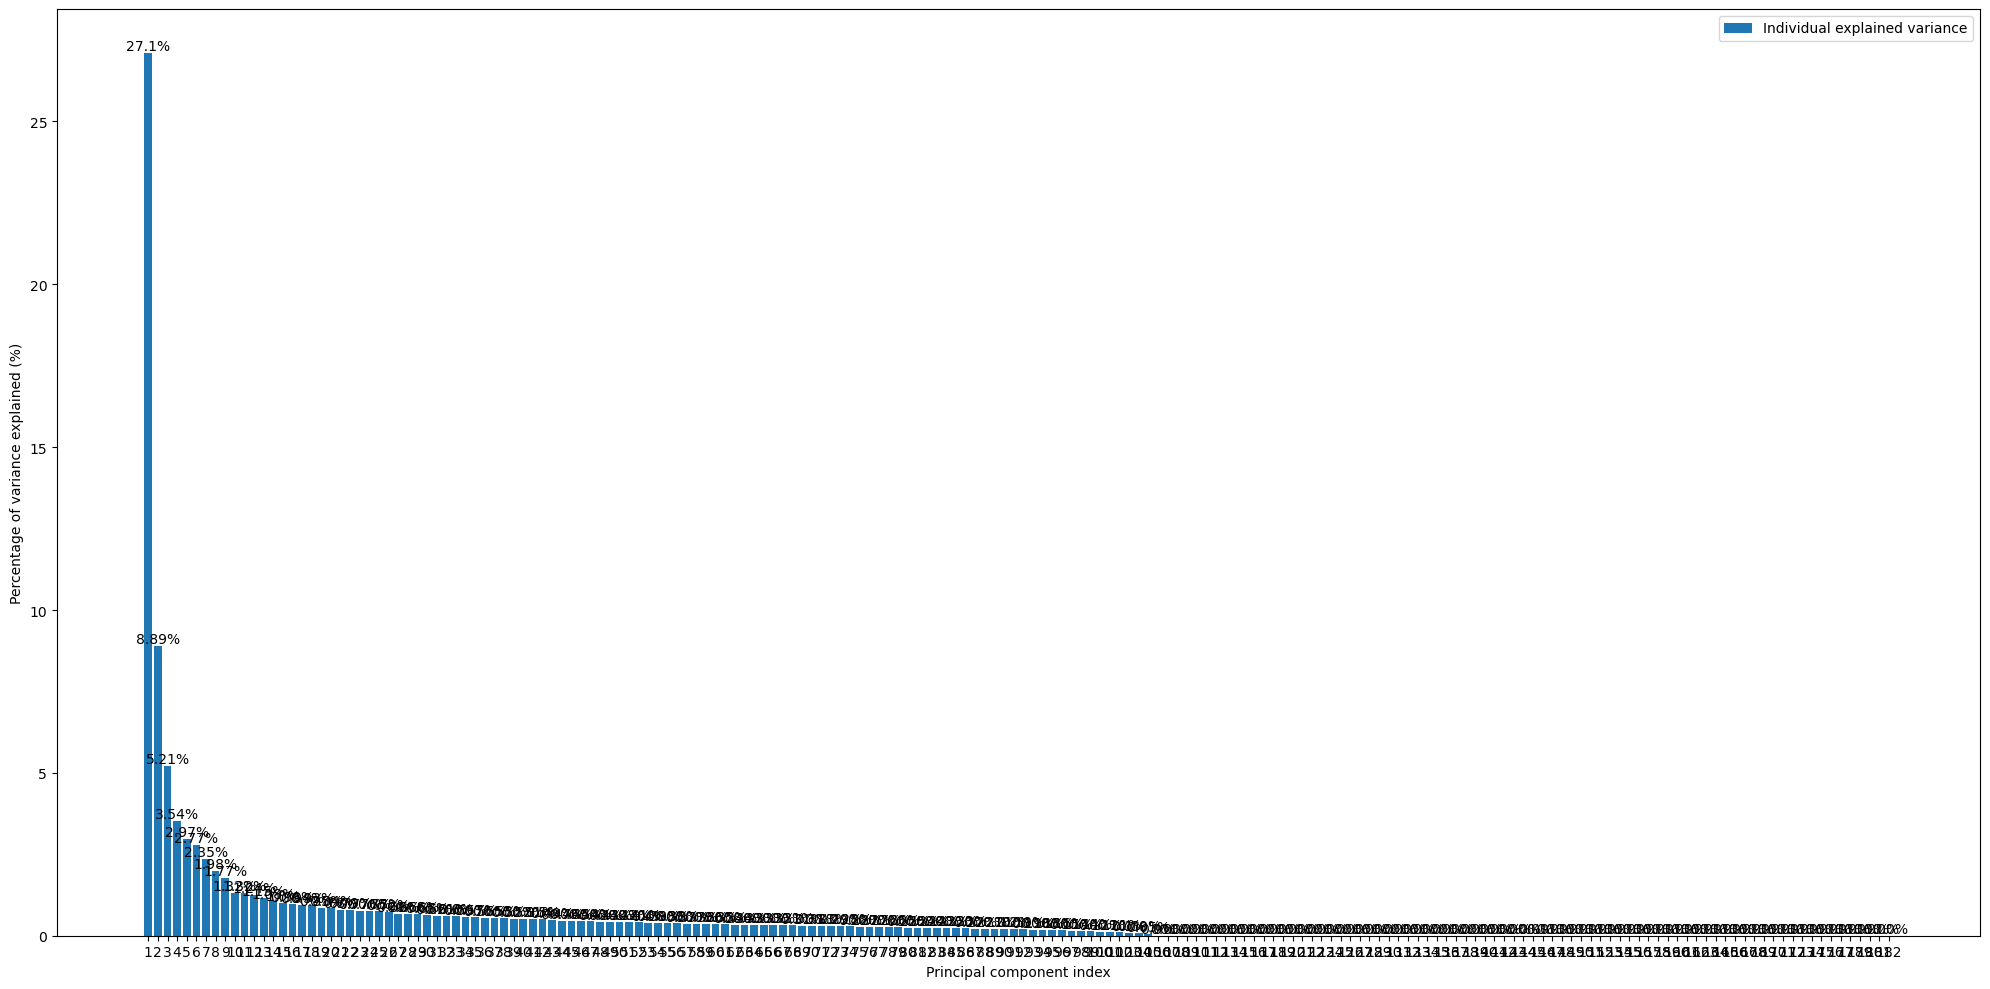

In [81]:
import matplotlib.pyplot as plt 

cov_mat = np.cov(x_train)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

exp_var = []

# Sort the eigenvalues in descending order
eigen_vals = np.sort(eigen_vals)[::-1]

for i in eigen_vals:
  var = (i / np.sum(eigen_vals)) * 100
  exp_var.append(var)


figure = plt.figure(figsize = (20, 10))

bar = plt.bar(range(1, len(exp_var)+1), exp_var, align='center',
        label='Individual explained variance')

# Adding data labels to the top of bars 
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{round(exp_var[i].real, 2)}%', 
             ha='center', va='bottom')

plt.ylabel('Percentage of variance explained (%)')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, len(exp_var)+1)))
plt.legend(loc='best')
plt.tight_layout()

In [82]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=3) 

new_data = pca.fit_transform(inputs) 

new_data

array([[-1.32977041e+02, -6.89190375e+01,  7.49951587e+01],
       [-1.21310666e+02, -5.32622426e+01,  5.80312292e+01],
       [-1.02965985e+02, -1.26700942e+01, -2.37627827e+01],
       [-1.16696319e+02, -7.89009095e+01,  8.16579210e+01],
       [-1.24790026e+02, -4.27851075e+01, -2.21907386e+01],
       [-1.01658715e+02,  7.67601558e-01, -8.78335789e+00],
       [-1.16306075e+02, -4.81096188e+01,  5.56673019e+01],
       [-1.28346807e+02, -3.97183961e+01,  5.85160489e+01],
       [-9.79874786e+01, -2.97718451e+01,  5.36524663e+01],
       [-1.11712004e+02, -5.24258787e+01,  4.95880060e+01],
       [-1.23427886e+02, -3.30313395e+01,  5.30416483e+01],
       [-1.16223842e+02, -2.41784616e+01, -2.31205335e+01],
       [-1.17186541e+02, -3.95148644e+01, -1.08788256e+00],
       [-1.08856569e+02, -1.17277797e+01, -2.19338145e+00],
       [-1.32945647e+02, -2.42528836e+01, -1.30069982e+01],
       [-1.31681703e+02, -3.89332172e+01,  6.44765370e+01],
       [-1.03479163e+02, -1.46981777e+01

In [83]:
import plotly.express as px 

px.scatter_3d(
    pd.DataFrame(new_data, columns = ['pc1', 'pc2', 'pc3']),
    color = labels,
    labels = labels,  
    x = 'pc1',
    y = 'pc2',
    z = 'pc3',
    opacity = 0.8
)